In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import mne

In [2]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

In [12]:
file_path = 'BCICIV_2a_gdf\A09T.gdf'  
raw = mne.io.read_raw_gdf(file_path,eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])



Extracting EDF parameters from C:\Users\21694\PFIN\BCICIV_2a_gdf\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


C:\Users\21694\anaconda3\lib\contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A09T.gdf, 22 x 673328 (2693.3 s), ~113.0 MB, data loaded>

In [13]:
fs = raw.info['sfreq']  # Sampling frequency
n_channels, n_samples = data.shape

mu_band = (8.0, 12.0)  # Mu frequency band (Hz)
beta_band = (16.0, 36.0)  # Beta frequency band (Hz)

mu_powers = []
beta_powers = []

for i in range(n_channels):
    channel_data = data[i, :]
    
    # Apply bandpass filter
    mu_filtered = butter_bandpass_filter(channel_data, mu_band[0], mu_band[1], fs)
    beta_filtered = butter_bandpass_filter(channel_data, beta_band[0], beta_band[1], fs)
    
    # Compute power (squared magnitude of the filtered signal)
    mu_power = np.mean(np.abs(mu_filtered) ** 2)
    beta_power = np.mean(np.abs(beta_filtered) ** 2)
    
    mu_powers.append(mu_power)
    beta_powers.append(beta_power)


In [11]:

events=mne.events_from_annotations(raw)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

In [15]:
events[0][0:20]

array([[     0,      0,      5],
       [     0,      0,      3],
       [ 30878,      0,      5],
       [ 30878,      0,      4],
       [ 54282,      0,      5],
       [ 54282,      0,      2],
       [ 92318,      0,      5],
       [ 92668,      0,      6],
       [ 92668,      0,      1],
       [ 93168,      0,     10],
       [ 94671,      0,      6],
       [ 95171,      0,      8],
       [ 96589,      0,      6],
       [ 97089,      0,      8],
       [ 98541,      0,      6],
       [ 98541,      0,      1],
       [ 99041,      0,      7],
       [100549,      0,      6],
       [100549,      0,      1],
       [101049,      0,     10]])

In [16]:
# Cue onset left (class 1)
#Cue onset right (class 2)
#Cue onset foot (class 3)
#Cue onset tongue (class 4)

event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,

}

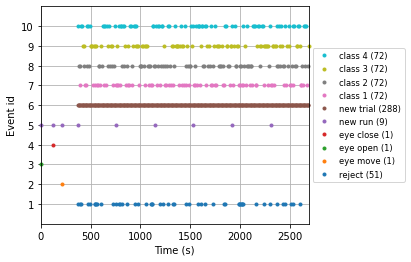

In [17]:
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

In [18]:
epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],tmin= -0.1, tmax=0.7, preload=True)  

Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped


In [19]:
epochs.get_data().shape

(288, 22, 201)

In [20]:
label=epochs.events[:,-1]
len(label)

288

In [21]:
evoked_0 = epochs['7'].average()
evoked_1 = epochs['8'].average()
evoked_2 = epochs['9'].average()
evoked_3 = epochs['10'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


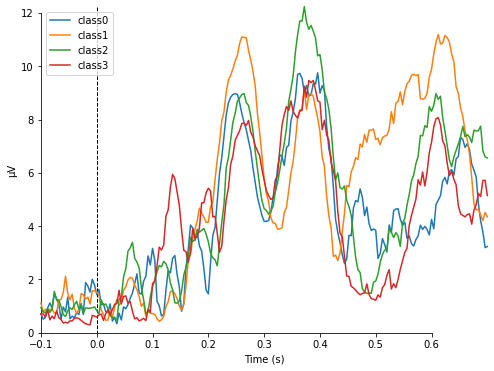

[<Figure size 576x432 with 1 Axes>]

In [22]:
#left,right,foot,tongue
dicts={'class0':evoked_0,'class1':evoked_1,'class2':evoked_2,'class3':evoked_3}
mne.viz.plot_compare_evokeds(dicts)
     

In [23]:

def read_data(path):
  raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
  raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
  raw.set_eeg_reference()
  events=mne.events_from_annotations(raw)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn')
  labels=epochs.events[:,-1]
  features=epochs.get_data()
  return features,labels



In [25]:

%%capture
features,labels,groups=[],[],[]
for i in range(1,10):
  feature,label=read_data(f'BCICIV_2a_gdf/A0{i}T.gdf')
  features.append(feature)
  labels.append(label)
  groups.append([i]*len(label))


In [26]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((2448, 22, 176), (2448,), (2448,))

In [27]:
np.isnan(features).sum()

0

In [28]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([ 7,  8,  9, 10]), array([648, 648, 576, 576], dtype=int64))

In [29]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([288, 288, 288, 144, 288, 288, 288, 288, 288], dtype=int64))

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have features and labels already defined
# features: (2448, 22, 176) - EEG data for each trial
# labels: (2448,) - Task labels (7: left, 8: right, 9: foot, 10: tongue)

# Reshape features for classification
num_trials, num_channels, num_samples = features.shape
reshaped_features = features.reshape(num_trials, num_channels * num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Support Vector Machine classifier
classifier = SVC(kernel='linear', C=1)
classifier.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = classifier.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[69 25 24 20]
 [30 53 21 22]
 [30 33 42 13]
 [18 27 21 42]]
              precision    recall  f1-score   support

           7       0.47      0.50      0.48       138
           8       0.38      0.42      0.40       126
           9       0.39      0.36      0.37       118
          10       0.43      0.39      0.41       108

    accuracy                           0.42       490
   macro avg       0.42      0.42      0.42       490
weighted avg       0.42      0.42      0.42       490



In [34]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# features: (2448, 22, 176) - EEG data for each trial
# labels: (2448,) - Task labels (7: left, 8: right, 9: foot, 10: tongue)

# Reshape features for CNN input
num_trials, num_channels, num_samples = features.shape
reshaped_features = features.reshape(num_trials, num_channels, num_samples, 1)  # Adding a channel dimension

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(reshaped_features.reshape(num_trials, -1))
scaled_features = scaled_features.reshape(num_trials, num_channels, num_samples, 1)

# Adjust labels to be 0 (left) or 1 (right)
adjusted_labels = np.where(labels == 7, 0, 1)

# Convert labels to categorical format
categorical_labels = to_categorical(adjusted_labels, num_classes=2)

# Define CNN architecture
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_channels, num_samples, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # 2 classes (left or right)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform 5-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(scaled_features, adjusted_labels)):
    print(f"Fold {fold_idx + 1} - Training")

    X_train, X_test = scaled_features[train_idx], scaled_features[test_idx]
    y_train, y_test = categorical_labels[train_idx], categorical_labels[test_idx]

    model = create_cnn_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    print(f"Fold {fold_idx + 1} - Testing")
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted labels
    y_true_labels = np.argmax(y_test, axis=1)  # True labels

    print(confusion_matrix(y_true_labels, y_pred_labels))
    print(classification_report(y_true_labels, y_pred_labels))

Fold 1 - Training
Epoch 1/10
62/62 [==============================] - 12s 96ms/step - loss: 0.6330 - accuracy: 0.7268 - val_loss: 0.5880 - val_accuracy: 0.7347
Epoch 2/10
62/62 [==============================] - 5s 84ms/step - loss: 0.5705 - accuracy: 0.7354 - val_loss: 0.5987 - val_accuracy: 0.7347
Epoch 3/10
62/62 [==============================] - 5s 85ms/step - loss: 0.5419 - accuracy: 0.7390 - val_loss: 0.5905 - val_accuracy: 0.7327
Epoch 4/10
62/62 [==============================] - 5s 85ms/step - loss: 0.5137 - accuracy: 0.7554 - val_loss: 0.5954 - val_accuracy: 0.7367
Epoch 5/10
62/62 [==============================] - 5s 84ms/step - loss: 0.4891 - accuracy: 0.7661 - val_loss: 0.5771 - val_accuracy: 0.7184
Epoch 6/10
62/62 [==============================] - 5s 82ms/step - loss: 0.4454 - accuracy: 0.7921 - val_loss: 0.6031 - val_accuracy: 0.6980
Epoch 7/10
62/62 [==============================] - 5s 83ms/step - loss: 0.4323 - accuracy: 0.7937 - val_loss: 0.6108 - val_accuracy: 0

62/62 [==============================] - 5s 87ms/step - loss: 0.4422 - accuracy: 0.7856 - val_loss: 0.5565 - val_accuracy: 0.7239
Epoch 9/10
62/62 [==============================] - 5s 86ms/step - loss: 0.4226 - accuracy: 0.7938 - val_loss: 0.5560 - val_accuracy: 0.7178
Epoch 10/10
62/62 [==============================] - 5s 83ms/step - loss: 0.3836 - accuracy: 0.8060 - val_loss: 0.6069 - val_accuracy: 0.7219
Fold 5 - Testing
[[ 23 106]
 [ 30 330]]
              precision    recall  f1-score   support

           0       0.43      0.18      0.25       129
           1       0.76      0.92      0.83       360

    accuracy                           0.72       489
   macro avg       0.60      0.55      0.54       489
weighted avg       0.67      0.72      0.68       489



In [38]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# features: (2448, 22, 176) - EEG data for each trial
# labels: (2448,) - Task labels (7: left, 8: right, 9: foot, 10: tongue)

# Filter out labels for binary classification (left vs. right)
binary_labels = labels[(labels == 7) | (labels == 8)]
binary_features = features[(labels == 7) | (labels == 8)]

# Reshape features for CNN input
num_trials, num_channels, num_samples = binary_features.shape
reshaped_features = binary_features.reshape(num_trials, num_channels, num_samples, 1)  # Adding a channel dimension

# Adjust labels to be 0 (left) or 1 (right)
adjusted_labels = np.where(binary_labels == 7, 0, 1)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(reshaped_features.reshape(num_trials, -1))
scaled_features = scaled_features.reshape(num_trials, num_channels, num_samples, 1)

# Convert labels to categorical format
categorical_labels = to_categorical(adjusted_labels, num_classes=4)
# Define CNN architecture
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_channels, num_samples, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # 4 classes (left or right)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Perform 5-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(scaled_features, adjusted_labels)):
    print(f"Fold {fold_idx + 1} - Training")

    X_train, X_test = scaled_features[train_idx], scaled_features[test_idx]
    y_train, y_test = categorical_labels[train_idx], categorical_labels[test_idx]

    model = create_cnn_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    print(f"Fold {fold_idx + 1} - Testing")
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted labels
    y_true_labels = np.argmax(y_test, axis=1)  # True labels

    print(confusion_matrix(y_true_labels, y_pred_labels))
    print(classification_report(y_true_labels, y_pred_labels))

Fold 1 - Training
Epoch 1/10
33/33 [==============================] - 3s 92ms/step - loss: 0.8392 - accuracy: 0.4739 - val_loss: 0.7070 - val_accuracy: 0.5154
Epoch 2/10
33/33 [==============================] - 3s 81ms/step - loss: 0.6924 - accuracy: 0.5936 - val_loss: 0.6770 - val_accuracy: 0.5808
Epoch 3/10
33/33 [==============================] - 3s 83ms/step - loss: 0.6347 - accuracy: 0.6486 - val_loss: 0.6814 - val_accuracy: 0.5731
Epoch 4/10
33/33 [==============================] - 3s 83ms/step - loss: 0.6067 - accuracy: 0.6660 - val_loss: 0.6644 - val_accuracy: 0.6231
Epoch 5/10
33/33 [==============================] - 3s 86ms/step - loss: 0.5555 - accuracy: 0.7297 - val_loss: 0.6652 - val_accuracy: 0.5923
Epoch 6/10
33/33 [==============================] - 3s 86ms/step - loss: 0.4972 - accuracy: 0.7625 - val_loss: 0.6313 - val_accuracy: 0.6385
Epoch 7/10
33/33 [==============================] - 3s 86ms/step - loss: 0.4218 - accuracy: 0.8118 - val_loss: 0.6675 - val_accuracy: 0.

33/33 [==============================] - 3s 90ms/step - loss: 0.3850 - accuracy: 0.8235 - val_loss: 0.7164 - val_accuracy: 0.6448
Epoch 9/10
33/33 [==============================] - 3s 90ms/step - loss: 0.3278 - accuracy: 0.8611 - val_loss: 0.7861 - val_accuracy: 0.6178
Epoch 10/10
33/33 [==============================] - 3s 84ms/step - loss: 0.2645 - accuracy: 0.8949 - val_loss: 0.8150 - val_accuracy: 0.6525
Fold 5 - Testing
[[70 60]
 [30 99]]
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       130
           1       0.62      0.77      0.69       129

    accuracy                           0.65       259
   macro avg       0.66      0.65      0.65       259
weighted avg       0.66      0.65      0.65       259



In [39]:
from sklearn.metrics import cohen_kappa_score

accuracy_scores = []
kappa_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(scaled_features, adjusted_labels)):
    X_train, X_test = scaled_features[train_idx], scaled_features[test_idx]
    y_train, y_test = categorical_labels[train_idx], categorical_labels[test_idx]

    model = create_cnn_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    accuracy = np.mean(y_pred_labels == y_true_labels)
    kappa = cohen_kappa_score(y_true_labels, y_pred_labels)

    accuracy_scores.append(accuracy)
    kappa_scores.append(kappa)

    print(f"Fold {fold_idx + 1} - Accuracy: {accuracy:.4f}, Kappa: {kappa:.4f}")

print("Accuracy Scores:", accuracy_scores)
print("Kappa Scores:", kappa_scores)


Epoch 1/10
33/33 [==============================] - 3s 90ms/step - loss: 0.8559 - accuracy: 0.4788 - val_loss: 0.7107 - val_accuracy: 0.5077
Epoch 2/10
33/33 [==============================] - 3s 83ms/step - loss: 0.6989 - accuracy: 0.5666 - val_loss: 0.6889 - val_accuracy: 0.5808
Epoch 3/10
33/33 [==============================] - 3s 89ms/step - loss: 0.6786 - accuracy: 0.5975 - val_loss: 0.6711 - val_accuracy: 0.5923
Epoch 4/10
33/33 [==============================] - 3s 81ms/step - loss: 0.6386 - accuracy: 0.6535 - val_loss: 0.6712 - val_accuracy: 0.6000
Epoch 5/10
33/33 [==============================] - 3s 83ms/step - loss: 0.6241 - accuracy: 0.6641 - val_loss: 0.6577 - val_accuracy: 0.5769
Epoch 6/10
33/33 [==============================] - 3s 89ms/step - loss: 0.5873 - accuracy: 0.6998 - val_loss: 0.6410 - val_accuracy: 0.6231
Epoch 7/10
33/33 [==============================] - 3s 82ms/step - loss: 0.5428 - accuracy: 0.7461 - val_loss: 0.6336 - val_accuracy: 0.6577
Epoch 8/10
33

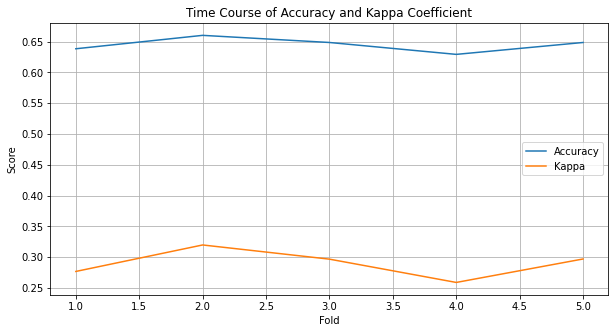

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), accuracy_scores, label="Accuracy")
plt.plot(range(1, n_splits + 1), kappa_scores, label="Kappa")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Time Course of Accuracy and Kappa Coefficient")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
best_fold = np.argmax(kappa_scores)
best_kappa = kappa_scores[best_fold]

print(f"Winner Algorithm - Fold: {best_fold + 1}, Kappa: {best_kappa:.4f}")


Winner Algorithm - Fold: 2, Kappa: 0.3199
